In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Download NLTK stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alesac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data

In [3]:
ts_data = pd.read_csv('data/taylor_swift_discography_updated.csv', sep=';', index_col = 'ID')
ts_data.head()

,track_name,track_musical_genre,track_type,duration_ms,feature,track_videoclip,videoclip_views,spotify_streams,spotify_global_peak,album,...,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
ID,,,,,,,,,,,,,,,,,,,,,
0,Fortnight (feat. Post Malone),Synth Pop,Single,228965,Post Malone,No,0,648525069,1,The Tortured Poets Department: The Anthology,...,spotify:track:6dODwocEuGzHAavXqTbwHv,0.5020,0.504,0.386,1.53e-05,0.0961,-10.976,0.0308,192.004,0.281
1,The Tortured Poets Department,Synth Pop,B-Side,293048,No,No,0,206954130,6,The Tortured Poets Department: The Anthology,...,spotify:track:4PdLaGZubp4lghChqp8erB,0.0483,0.604,0.428,0.0,0.1260,-8.441,0.0255,110.259,0.292
2,My Boy Only Breaks His Favorite Toys,Synth Pop,B-Side,203801,No,No,0,238016975,7,The Tortured Poets Department: The Anthology,...,spotify:track:7uGYWMwRy24dm7RUDDhUlD,0.1370,0.596,0.563,0.0,0.3020,-7.362,0.0269,97.073,0.481
3,Down Bad,R&B,B-Side,261228,No,No,0,318375377,2,The Tortured Poets Department: The Anthology,...,spotify:track:1kbEbBdEgQdQeLXCJh28pJ,0.5600,0.541,0.366,"1,00E-06",0.0946,-10.412,0.0748,159.707,0.168
4,"So Long, London",Synth Pop,B-Side,262974,No,No,0,253712712,4,The Tortured Poets Department: The Anthology,...,spotify:track:7wAkQFShJ27V8362MqevQr,0.7300,0.423,0.533,0.00264,0.0816,-11.388,0.3220,160.218,0.248


In [4]:
#print size of the dataset
rows, columns = ts_data.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  577
Number of columns:  27


In [5]:
# print name of columns
print(ts_data.columns)

Index(['track_name', 'track_musical_genre', 'track_type', 'duration_ms',
       'feature', 'track_videoclip', 'videoclip_views', 'spotify_streams',
       'spotify_global_peak', 'album', 'track_number', 'album_musical_genre',
       'album_type', 'release_date', 'album_physical_sales', 'track_lyrics',
       'track_theme', 'uri', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')


In [6]:
# chnage the type of certain columns of the dataset
ts_data['release_date'] = pd.to_datetime(ts_data['release_date'], format='%d/%m/%Y')
ts_data['spotify_streams'] = ts_data['spotify_streams'].str.replace('.', '')
ts_data['spotify_streams'] = pd.to_numeric(ts_data['spotify_streams'], errors='coerce')

### We know that there are duplicates, let's print for each song the number of times it appears

In [7]:
print(ts_data['track_name'].value_counts())

track_name
Sweet Nothing                           3
Karma                                   3
Labyrinth                               3
Bejeweled                               3
Maroon                                  3
                                       ..
Stay Beautiful                          1
Should've Said No                       1
Mary's Song (Oh My My My)               1
A Perfectly Good Heart                  1
Teardrops on My Guitar - Pop Version    1
Name: count, Length: 361, dtype: int64


In [8]:
# text_columns = [
#     'track_musical_genre', 'track_type', 'feature', 'track_videoclip', 
#     'album', 'track_number', 'album_musical_genre', 'album_type', 
#     'track_lyrics', 'track_theme', 'uri', 'release_date'
# ]
# numerical_columns = [
#     'duration_ms', 'videoclip_views', 'spotify_streams', 'spotify_global_peak', 
#     'album_physical_sales', 'acousticness', 'danceability', 'energy', 
#     'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
# ]

# def merge_values(column_values):
#     unique_values = column_values.dropna().unique()
#     if len(unique_values) == 1:
#         return unique_values[0]  # Return single value if all values are the same
#     else:
#         return list(unique_values)  # Return list of unique values if there are multiple

# # Group by 'track_name' and aggregate
# merged_data = ts_data.groupby('track_name').agg(
#     {col: merge_values for col in text_columns + numerical_columns}
# ).reset_index()

# # Display the merged data
# merged_data.head()


### Remove the '(Taylor's Version)'

In [9]:
# # def simplify_title(title):
# #     """Simplify title by removing any version indicators like '(Taylor's Version)'."""
# #     return re.sub(r"\(.*?\)", "", title).strip()

# def simplify_title(title):
#     """Simplify title by removing only '(Taylor's Version)'."""
#     return re.sub(r"\(Taylor's Version\)", "", title).strip()

# def merge_values(column_values):
#     # Flatten lists in column_values
#     flattened_values = []
#     for value in column_values.dropna():
#         if isinstance(value, list):
#             flattened_values.extend(value)  # Unpack list values into flattened_values
#         else:
#             flattened_values.append(value)
    
#     # Convert to a unique set and back to list for further processing
#     unique_values = pd.Series(flattened_values).unique()
    
#     if len(unique_values) == 1:
#         return unique_values[0]  # Return single unique value if all values are the same
#     else:
#         return list(unique_values)  # Return list of unique values if there are multiple

# # Group by 'simplified_title' and aggregate with the modified function
# merged_data['simplified_title'] = merged_data['track_name'].apply(simplify_title)
# final_merged_data = merged_data.groupby('simplified_title').agg(
#     {col: merge_values for col in text_columns + numerical_columns}
# ).reset_index()

# # Rename 'simplified_title' back to 'track_name' for clarity
# final_merged_data.rename(columns={'simplified_title': 'track_name'}, inplace=True)

# # Display the final merged data
# final_merged_data.head()



In [10]:
# print(final_merged_data.columns)

In [11]:
# #print size of the dataset
# rows, columns = final_merged_data.shape
# print('Number of rows: ', rows)
# print('Number of columns: ', columns)

# Build the network

### Clean the lyrics

In [12]:
# Define text cleaning function
def clean_text(text):
    # If the input is a list, join elements into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [13]:
# Apply text cleaning
ts_data['cleaned_lyrics'] = ts_data['track_lyrics'].apply(clean_text)

# Display the cleaned data
ts_data[['track_name', 'cleaned_lyrics']].head()

,track_name,cleaned_lyrics
ID,,
0,Fortnight (feat. Post Malone),supposed sent away forgot come get functioning...
1,The Tortured Poets Department,left typewriter apartment straight tortured po...
2,My Boy Only Breaks His Favorite Toys,oh go voices head called rain end days wild si...
3,Down Bad,really beam cloud sparkling dust experiments t...
4,"So Long, London",saw mind fairy lights mist kept calm carried w...


### Compute similarity between songs using tf-idf score and consine similarity

In [14]:
# Calculate TF-IDF scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(ts_data['cleaned_lyrics'])

In [15]:
# Step 1: Get feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 2: Convert the TF-IDF matrix to a DataFrame for easier inspection
# Use song titles (or any unique identifier) as row indices
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=ts_data['track_name'])

# Step 3: Display the first few rows of the TF-IDF DataFrame
tfidf_df.head()


,158,16th,17,1830s,1944,1950s,1958,2003,230,25,...,youi,youll,young,younger,youplease,youre,youth,youve,zayn,zlister
track_name,,,,,,,,,,,,,,,,,,,,,
Fortnight (feat. Post Malone),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.081502,0.00000,0.0,0.0,0.0
The Tortured Poets Department,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.052223,0.00000,0.0,0.0,0.0
My Boy Only Breaks His Favorite Toys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
Down Bad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"So Long, London",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.080645,0.0,0.0,0.0,0.025640,0.08779,0.0,0.0,0.0


In [16]:
# Step 3: Compute similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Convert similarity matrix to a DataFrame for easier manipulation
similarity_df = pd.DataFrame(similarity_matrix, index=ts_data['track_name'], columns=ts_data['track_name'])

# Display a sample of the similarity matrix
similarity_df.head(10)

track_name,Fortnight (feat. Post Malone),The Tortured Poets Department,My Boy Only Breaks His Favorite Toys,Down Bad,"So Long, London",But Daddy I Love Him,Fresh Out The Slammer,Florida!!! (feat. Florence + The Machine),Guilty as Sin?,Who's Afraid of Little Old Me?,...,The Outside,Tied Together with a Smile,Stay Beautiful,Should've Said No,Mary's Song (Oh My My My),Our Song,I'm Only Me When I'm With You,Invisible,A Perfectly Good Heart,Teardrops on My Guitar - Pop Version
track_name,,,,,,,,,,,,,,,,,,,,,
Fortnight (feat. Post Malone),1.000000,0.014429,0.014589,0.027823,0.014152,0.028550,0.002407,0.122072,0.012219,0.022496,...,0.010438,0.062617,0.053622,0.012989,0.030009,0.009440,0.038551,0.047066,0.058414,0.031598
The Tortured Poets Department,0.014429,1.000000,0.060466,0.010825,0.024085,0.028057,0.087525,0.014954,0.041494,0.303192,...,0.051741,0.093069,0.087184,0.013980,0.024491,0.013537,0.048635,0.071961,0.008836,0.069870
My Boy Only Breaks His Favorite Toys,0.014589,0.060466,1.000000,0.018626,0.049066,0.109410,0.071283,0.019276,0.029756,0.032486,...,0.037445,0.042873,0.034744,0.150398,0.041144,0.042915,0.094434,0.044082,0.050028,0.089951
Down Bad,0.027823,0.010825,0.018626,1.000000,0.063639,0.049098,0.021384,0.032152,0.067059,0.047330,...,0.011040,0.047508,0.050650,0.062255,0.062336,0.014662,0.057574,0.080004,0.063631,0.039045
"So Long, London",0.014152,0.024085,0.049066,0.063639,1.000000,0.060489,0.038286,0.040911,0.048315,0.024801,...,0.027081,0.066371,0.071111,0.041957,0.060086,0.048295,0.068597,0.046012,0.032287,0.032687
But Daddy I Love Him,0.028550,0.028057,0.109410,0.049098,0.060489,1.000000,0.097940,0.057548,0.068837,0.039175,...,0.079630,0.093015,0.071972,0.025901,0.065910,0.040706,0.148265,0.097641,0.022426,0.173088
Fresh Out The Slammer,0.002407,0.087525,0.071283,0.021384,0.038286,0.097940,1.000000,0.030138,0.051401,0.030312,...,0.057303,0.078994,0.063008,0.060630,0.104425,0.040782,0.103777,0.074866,0.026974,0.037746
Florida!!! (feat. Florence + The Machine),0.122072,0.014954,0.019276,0.032152,0.040911,0.057548,0.030138,1.000000,0.025082,0.048826,...,0.030851,0.046500,0.068829,0.027766,0.084642,0.023730,0.052266,0.013477,0.020104,0.028245
Guilty as Sin?,0.012219,0.041494,0.029756,0.067059,0.048315,0.068837,0.051401,0.025082,1.000000,0.018938,...,0.035495,0.048291,0.068514,0.025291,0.044903,0.040954,0.041484,0.048424,0.011191,0.108148


In [17]:
# Filter the similarity matrix based on the conditions
filtered_similarity = similarity_df[(similarity_df > 0.95)]

# Get the indices and values of the filtered values
filtered_pairs = filtered_similarity.stack()

# Extract unique song pairs with their similarity scores
couples_with_scores = set()  # Use a set to avoid duplicates
for (song1, song2), score in filtered_pairs.items():
    if song1 != song2:  # Exclude self-similarity
        # Sort song names to remove symmetric duplicates
        pair = tuple(sorted([song1, song2]))
        couples_with_scores.add((pair[0], pair[1], score))

# Print the unique couples with their similarity scores
for song1, song2, score in couples_with_scores:
    print(f"({song1}, {song2}): {score:.4f}")



(Long Live (Taylor's Version), Long Live - Live/2011): 1.0000
(peace, peace - the long pond studio sessions): 1.0000
(Mine (Taylor's Version), Mine - POP Mix): 1.0000
(Come Back...Be Here, Come Back...Be Here (Taylor's Version)): 1.0000
(Untouchable, Untouchable - Live From Clear Channel Stripped 2008): 1.0000
(cardigan, cardigan - the long pond studio sessions): 1.0000
(Haunted (Taylor's Version), Haunted - Live/2011): 1.0000
(Dear John, Dear John - Live/2011): 1.0000
(The Best Day, The Best Day (Taylor's Version)): 1.0000
(Last Kiss, Last Kiss (Taylor's Version)): 1.0000
(Haunted, Haunted - Live/2011): 1.0000
(Teardrops On My Guitar - Radio Single Remix, Teardrops on My Guitar - Pop Version): 1.0000
(Style, Style (Taylor's Version)): 1.0000
(exile (feat. Bon Iver), exile (feat. Bon Iver) - the long pond studio sessions): 1.0000
(Blank Space, Blank Space - Voice Memo): 1.0000
(Blank Space, Blank Space (Taylor's Version)): 1.0000
(Untouchable (Taylor's Version), Untouchable - Live From

In [18]:
def merge_rows(row1, row2, text_columns, numerical_columns):
    merged_row = {}
    
    # Use the shortest track name
    merged_row['track_name'] = row1['track_name'] if len(row1['track_name']) < len(row2['track_name']) else row2['track_name']
    
    # Merge text columns
    for col in text_columns:
        values = []
        # Handle existing lists in attributes
        for value in [row1[col], row2[col]]:
            if isinstance(value, list):
                values.extend(value)
            else:
                values.append(value)
        # Remove duplicates and keep unique values
        unique_values = pd.Series(values).dropna().unique()
        merged_row[col] = unique_values[0] if len(unique_values) == 1 else list(unique_values)
    
    # Merge numerical columns (same logic as text columns)
    for col in numerical_columns:
        values = []
        for value in [row1[col], row2[col]]:
            if isinstance(value, list):
                values.extend(value)
            else:
                values.append(value)
        unique_values = pd.Series(values).dropna().unique()
        merged_row[col] = unique_values[0] if len(unique_values) == 1 else list(unique_values)
    
    return merged_row



In [19]:
text_columns = [
    'track_musical_genre', 'track_type', 'feature', 'track_videoclip', 
    'album', 'track_number', 'album_musical_genre', 'album_type', 
    'track_lyrics', 'track_theme', 'uri', 'release_date', 'cleaned_lyrics'
]
numerical_columns = [
    'duration_ms', 'videoclip_views', 'spotify_streams', 'spotify_global_peak', 
    'album_physical_sales', 'acousticness', 'danceability', 'energy', 
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# Copy the data to avoid modifying the original during iteration
updated_ts_data = ts_data.copy()

# Iterate over the couples and merge their rows
for song1, song2, _ in couples_with_scores:
    print(song1,song2)
    try:
        row1 = updated_ts_data.loc[updated_ts_data['track_name'] == song1].iloc[0]
        row2 = updated_ts_data.loc[updated_ts_data['track_name'] == song2].iloc[0]
        
        # Merge the two rows
        merged_row = merge_rows(row1, row2, text_columns, numerical_columns)
        
        # Drop the original rows
        updated_ts_data = updated_ts_data[~updated_ts_data['track_name'].isin([song1, song2])]
        
        # Add the merged row back to the dataset
        updated_ts_data = pd.concat([updated_ts_data, pd.DataFrame([merged_row])], ignore_index=True)
    except IndexError:
        # If one of the rows has already been merged, skip this pair
        continue

# Update the original ts_data with the modified dataset
ts_data = updated_ts_data.copy()
print(ts_data.shape)
# Display the updated dataset
ts_data.head(10)


Long Live (Taylor's Version) Long Live - Live/2011
peace peace - the long pond studio sessions
Mine (Taylor's Version) Mine - POP Mix
Come Back...Be Here Come Back...Be Here (Taylor's Version)
Untouchable Untouchable - Live From Clear Channel Stripped 2008
cardigan cardigan - the long pond studio sessions
Haunted (Taylor's Version) Haunted - Live/2011
Dear John Dear John - Live/2011
The Best Day The Best Day (Taylor's Version)
Last Kiss Last Kiss (Taylor's Version)
Haunted Haunted - Live/2011
Teardrops On My Guitar - Radio Single Remix Teardrops on My Guitar - Pop Version
Style Style (Taylor's Version)
exile (feat. Bon Iver) exile (feat. Bon Iver) - the long pond studio sessions
Blank Space Blank Space - Voice Memo
Blank Space Blank Space (Taylor's Version)
Untouchable (Taylor's Version) Untouchable - Live From Clear Channel Stripped 2008
Red (Taylor's Version) Red - Original Demo Recording
Back To December Back To December (Taylor's Version)
Holy Ground Holy Ground (Taylor's Version)


We Are Never Ever Getting Back Together We Are Never Ever Getting Back Together (Taylor's Version)
I Knew You Were Trouble I Knew You Were Trouble.
New Romantics New Romantics (Taylor's Version)
Wildest Dreams Wildest Dreams (Taylor's Version)
All Too Well All Too Well (Taylor's Version)
the last great american dynasty the last great american dynasty - the long pond studio sessions
Teardrops On My Guitar - Live From Clear Channel Stripped 2008 Teardrops On My Guitar - Radio Single Remix
Wonderland Wonderland (Taylor's Version)
Forever & Always (Piano Version) (Taylor's Version) Forever & Always (Taylor's Version)
Haunted Haunted - Acoustic Version
All You Had To Do Was Stay All You Had To Do Was Stay (Taylor's Version)
The Story Of Us (Taylor's Version) The Story Of Us - Live
White Horse White Horse (Taylor's Version)
the lakes - bonus track the lakes - the long pond studio sessions
Dear John Dear John (Taylor's Version)
I Almost Do I Almost Do (Taylor's Version)
illicit affairs illici

,track_name,track_musical_genre,track_type,duration_ms,feature,track_videoclip,videoclip_views,spotify_streams,spotify_global_peak,album,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,cleaned_lyrics
0,Fortnight (feat. Post Malone),Synth Pop,Single,228965,Post Malone,No,0,648525069,1,The Tortured Poets Department: The Anthology,...,0.502,0.504,0.386,1.53e-05,0.0961,-10.976,0.0308,192.004,0.281,supposed sent away forgot come get functioning...
1,The Tortured Poets Department,Synth Pop,B-Side,293048,No,No,0,206954130,6,The Tortured Poets Department: The Anthology,...,0.0483,0.604,0.428,0.0,0.126,-8.441,0.0255,110.259,0.292,left typewriter apartment straight tortured po...
2,My Boy Only Breaks His Favorite Toys,Synth Pop,B-Side,203801,No,No,0,238016975,7,The Tortured Poets Department: The Anthology,...,0.137,0.596,0.563,0.0,0.302,-7.362,0.0269,97.073,0.481,oh go voices head called rain end days wild si...
3,Down Bad,R&B,B-Side,261228,No,No,0,318375377,2,The Tortured Poets Department: The Anthology,...,0.56,0.541,0.366,"1,00E-06",0.0946,-10.412,0.0748,159.707,0.168,really beam cloud sparkling dust experiments t...
4,"So Long, London",Synth Pop,B-Side,262974,No,No,0,253712712,4,The Tortured Poets Department: The Anthology,...,0.73,0.423,0.533,0.00264,0.0816,-11.388,0.322,160.218,0.248,saw mind fairy lights mist kept calm carried w...
5,But Daddy I Love Him,Pop Rock,B-Side,340428,No,No,0,229410536,9,The Tortured Poets Department: The Anthology,...,0.384,0.521,0.72,0.0,0.135,-7.684,0.104,79.943,0.438,forget west forget ever fun learned people rai...
6,Fresh Out The Slammer,Pop Rock,B-Side,210789,No,No,0,145088911,18,The Tortured Poets Department: The Anthology,...,0.624,0.33,0.483,0.0,0.111,-9.394,0.0399,87.115,0.34,pretty baby im running back home fresh slammer...
7,Florida!!! (feat. Florence + The Machine),Indie Rock,B-Side,215463,Florence + The Machine,No,0,201272168,10,The Tortured Poets Department: The Anthology,...,0.178,0.533,0.573,0.0,0.309,-7.123,0.138,150.088,0.398,beat heat beat charges said cheat guess must t...
8,Guilty as Sin?,Pop Rock,B-Side,254365,No,No,0,280299504,14,The Tortured Poets Department: The Anthology,...,0.607,0.626,0.428,0.0,0.0921,-8.374,0.0261,94.95,0.487,drowning blue nile sent downtown lights hadnt ...
9,Who's Afraid of Little Old Me?,Pop Rock,B-Side,334084,No,No,0,257244561,12,The Tortured Poets Department: The Anthology,...,0.315,0.606,0.338,0.0,0.106,-10.555,0.048,119.88,0.238,whos whos poised attack bare hands paved paths...


In [20]:
ts_data.loc[ts_data['track_name'] =='Red']

,track_name,track_musical_genre,track_type,duration_ms,feature,track_videoclip,videoclip_views,spotify_streams,spotify_global_peak,album,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,cleaned_lyrics
278,Red,"[Pop Rock, Pop Rock ]","[Single, B-Side, Voice Memo]","[223093, 226280]",No,No,0,"[251775054, 276457730, 17531943]","[34, 4, 0]",[reputation Stadium Tour Surprise Song Playlis...,...,"[0.0779, 0.00108, 0.113]","[0.605, 0.516, 0.678]","[0.899, 0.777, 0.902]","[0.000125, 1.62e-06, 0.000235]","[0.0911, 0.0761, 0.0722]","[-4.273, -4.908, -4.659]","[0.0423, 0.0375, 0.0358]","[124.985, 125.047, 124.998]","[0.647, 0.408, 0.637]",loving like driving new maserati deadend stree...


In [ ]:
# Redo similairty matrix to do the graph 

In [21]:
# Define a similarity threshold to determine if a connection should be made
similarity_threshold = 0.2  # Adjust based on your preference

# Initialize a directed graph
G = nx.DiGraph()

def get_earliest_date(dates):
    # Check if dates is already in list format; if not, make it a list
    if not isinstance(dates, list):
        dates = [dates]
    # Convert to datetime and find the earliest date
    return min(pd.to_datetime(dates, dayfirst=True))

# Step 1: Add nodes (songs) to the graph
for song in ts_data['track_name']:
    G.add_node(song, release_date=ts_data.loc[ts_data['track_name'] == song, 'release_date'].values[0])

# Step 2: Add edges based on similarity and release date
for i, song1 in enumerate(ts_data['track_name']):
    for j, song2 in enumerate(ts_data['track_name']):
        if i != j:
            similarity_score = similarity_df.loc[song1, song2]
            if similarity_score > similarity_threshold:
                # Get release dates for both songs
                date1_raw = ts_data.loc[ts_data['track_name'] == song1, 'release_date'].values[0]
                date2_raw = ts_data.loc[ts_data['track_name'] == song2, 'release_date'].values[0]

                date1 = get_earliest_date(date1_raw)
                date2 = get_earliest_date(date2_raw)

                # Add a directed edge from the older song to the newer one
                if date1 < date2:
                    G.add_edge(song1, song2, weight=similarity_score)
                elif date2 < date1:
                    G.add_edge(song2, song1, weight=similarity_score)

# Step 3: Visualize the network
plt.figure(figsize=(12, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), edge_color='gray', alpha=0.5)

# Add labels to some nodes for clarity
labels = {node: node for node in G.nodes() if G.degree[node] > 1}  # Show labels only for nodes with multiple connections
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_family="sans-serif")

plt.title("Lyrics-Based Song Similarity Network")
plt.axis("off")
plt.show()


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Compute network based on number of words that the songs have in common and choosing the one that maximize the modularity

In [21]:
def get_top_n_words(tfidf_row, feature_names, n):
    """Returns the top N words for a song based on TF-IDF scores."""
    sorted_indices = tfidf_row.argsort()[::-1][:n]
    return set(feature_names[i] for i in sorted_indices)

In [22]:
from networkx.algorithms.components import connected_components
from networkx.algorithms.community import greedy_modularity_communities

results = []

for n_top_words in range(2, 10):
    # Initialize a new directed graph for each threshold
    G = nx.DiGraph()
    
    # Add nodes with song attributes
    for song in final_merged_data['track_name']:
        G.add_node(song, release_date=final_merged_data.loc[final_merged_data['track_name'] == song, 'release_date'].values[0])
    
    # Add edges based on the similarity of top words
    for i, song1 in enumerate(final_merged_data['track_name']):
        top_words1 = get_top_n_words(tfidf_matrix[i, :].toarray()[0], feature_names, n_top_words)
        for j, song2 in enumerate(final_merged_data['track_name']):
            if i < j:
                top_words2 = get_top_n_words(tfidf_matrix[j, :].toarray()[0], feature_names, n_top_words)
                
                # Check if there is sufficient overlap in top words
                common_words = top_words1.intersection(top_words2)
                if len(common_words) > 0:  # Link if there's at least one common word
                    date1_raw = final_merged_data.loc[final_merged_data['track_name'] == song1, 'release_date'].values[0]
                    date2_raw = final_merged_data.loc[final_merged_data['track_name'] == song2, 'release_date'].values[0]
                    date1 = get_earliest_date(date1_raw)
                    date2 = get_earliest_date(date2_raw)
                    
                    if date1 < date2:
                        G.add_edge(song1, song2)
                    elif date2 < date1:
                        G.add_edge(song2, song1)
    
    # Calculate the size of the largest connected component (GCC)
    if len(G) > 0:
        GCC = max(connected_components(G.to_undirected()), key=len)
        gcc_size = len(GCC)
        
        # Calculate modularity using community detection
        communities = list(greedy_modularity_communities(G.to_undirected()))
        modularity = nx.algorithms.community.quality.modularity(G.to_undirected(), communities)
    else:
        gcc_size = 0
        modularity = 0

    # Store the results
    results.append((n_top_words, gcc_size, modularity))


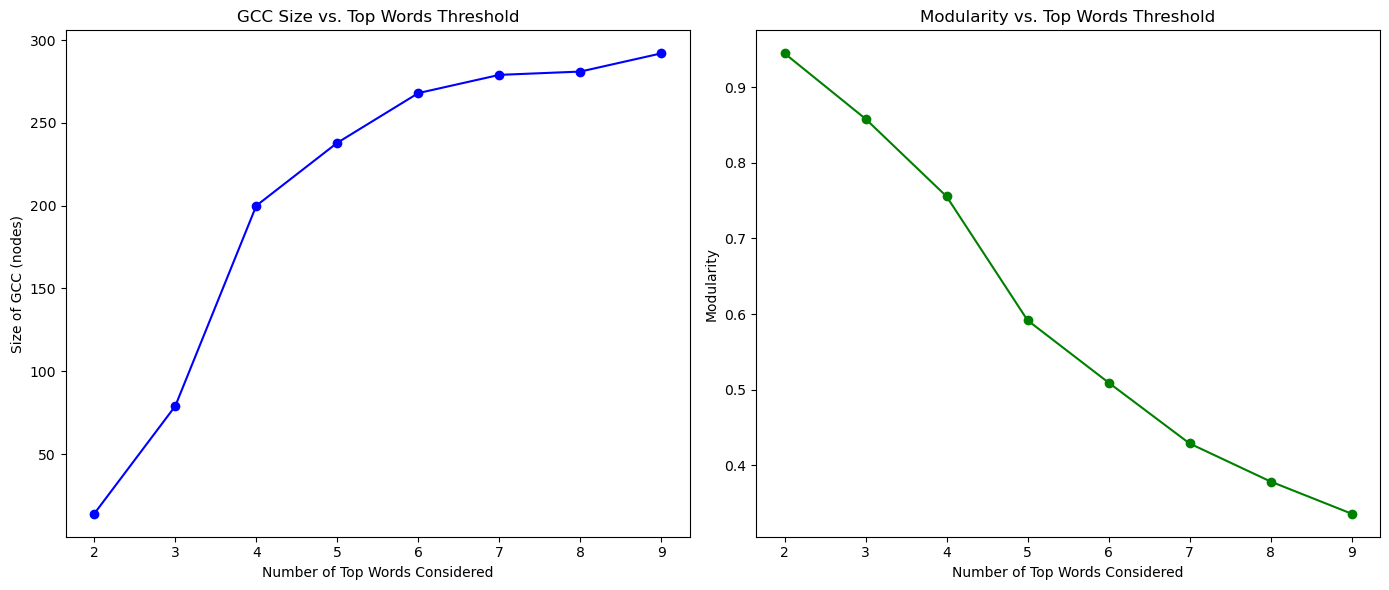

In [23]:
import matplotlib.pyplot as plt

thresholds = [res[0] for res in results]
gcc_sizes = [res[1] for res in results]
modularities = [res[2] for res in results]

plt.figure(figsize=(14, 6))

# Plot GCC size
plt.subplot(1, 2, 1)
plt.plot(thresholds, gcc_sizes, marker='o', color='b')
plt.xlabel("Number of Top Words Considered")
plt.ylabel("Size of GCC (nodes)")
plt.title("GCC Size vs. Top Words Threshold")

# Plot modularity
plt.subplot(1, 2, 2)
plt.plot(thresholds, modularities, marker='o', color='g')
plt.xlabel("Number of Top Words Considered")
plt.ylabel("Modularity")
plt.title("Modularity vs. Top Words Threshold")

plt.tight_layout()
plt.show()


/home/alesac/miniconda/envs/social_graph/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


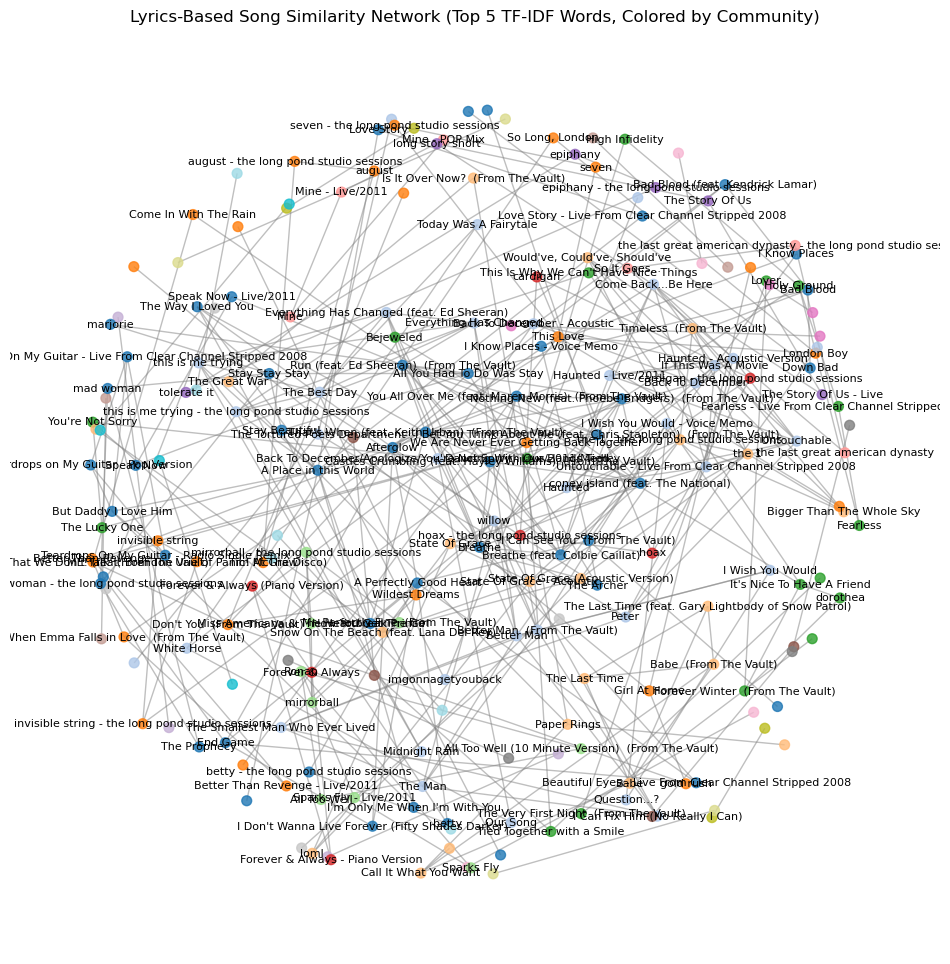

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

# Step 1: Filter the TF-IDF matrix to keep only the top 5 words for each song
top_n = 5  # Number of top TF-IDF words to consider
filtered_tfidf_matrix = tfidf_matrix.copy()

# Zero out values that are not among the top 5 highest scores per song
for i in range(filtered_tfidf_matrix.shape[0]):
    top_indices = filtered_tfidf_matrix[i].toarray().argsort()[0, -top_n:]  # Get indices of top 5 scores
    mask = np.ones(filtered_tfidf_matrix.shape[1], dtype=bool)  # Create a mask
    mask[top_indices] = False  # Invert mask for the top indices
    filtered_tfidf_matrix[i, mask] = 0  # Set non-top indices to 0

# Step 2: Compute the similarity matrix based on the filtered TF-IDF matrix
similarity_matrix_top5 = cosine_similarity(filtered_tfidf_matrix)
similarity_df_top5 = pd.DataFrame(similarity_matrix_top5, index=final_merged_data['track_name'], columns=final_merged_data['track_name'])

# Step 3: Create the network based on a similarity threshold
similarity_threshold = 0.2  # Define an appropriate similarity threshold for linking
G_top5 = nx.Graph()  # Use an undirected graph for community detection

# Add edges based on the similarity threshold
for i, song1 in enumerate(final_merged_data['track_name']):
    for j, song2 in enumerate(final_merged_data['track_name']):
        if i != j:
            similarity_score = similarity_df_top5.loc[song1, song2]
            if similarity_score > similarity_threshold:
                G_top5.add_edge(song1, song2, weight=similarity_score)

# Step 4: Detect communities using the greedy modularity algorithm
communities = list(greedy_modularity_communities(G_top5))
community_map = {}
for community_index, community in enumerate(communities):
    for node in community:
        community_map[node] = community_index

# Step 5: Plot the network with nodes colored by community
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_top5, k=0.5, seed=42)  # Use spring layout for better visualization

# Draw nodes with color based on their community
colors = [community_map[node] for node in G_top5.nodes()]
nx.draw_networkx_nodes(G_top5, pos, node_size=50, node_color=colors, cmap=plt.cm.tab20, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G_top5, pos, edge_color='gray', alpha=0.5)

# Optional: Add labels to a subset of nodes for clarity
labels = {node: node for node in G_top5.nodes() if G_top5.degree[node] > 1}
nx.draw_networkx_labels(G_top5, pos, labels, font_size=8, font_family="sans-serif")

plt.title("Lyrics-Based Song Similarity Network (Top 5 TF-IDF Words, Colored by Community)")
plt.axis("off")
plt.show()


In [25]:
# Step 4: Detect communities using the greedy modularity algorithm
communities = list(greedy_modularity_communities(G_top5))

# Print the number of communities
print(f"Number of communities detected: {len(communities)}")

Number of communities detected: 41


### Degree distribution

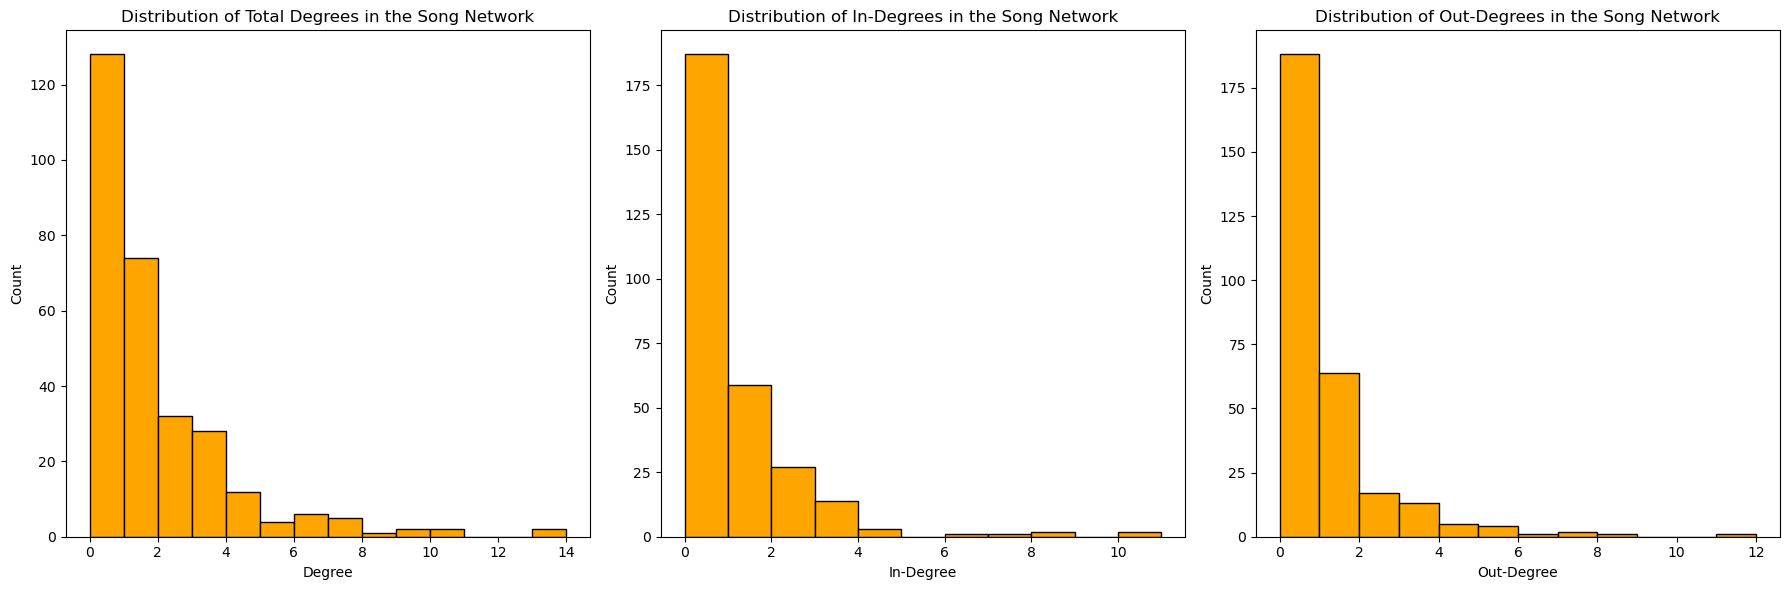

In [19]:
# Calculate degree, in-degree, and out-degree for each node
degrees = [d for n, d in G.degree()]
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total Degree Distribution
axes[0].hist(degrees, bins=range(0, max(degrees) + 1), color='orange', edgecolor='black')
axes[0].set_title('Distribution of Total Degrees in the Song Network')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')

# In-Degree Distribution
axes[1].hist(in_degrees, bins=range(0, max(in_degrees) + 1), color='orange', edgecolor='black')
axes[1].set_title('Distribution of In-Degrees in the Song Network')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Count')

# Out-Degree Distribution
axes[2].hist(out_degrees, bins=range(0, max(out_degrees) + 1), color='orange', edgecolor='black')
axes[2].set_title('Distribution of Out-Degrees in the Song Network')
axes[2].set_xlabel('Out-Degree')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [20]:
from tabulate import tabulate

# Find the top 5 songs with the highest in-degree
top_in_degree = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
in_degree_table = [[song, degree] for song, degree in top_in_degree]

# Find the top 5 songs with the highest out-degree
top_out_degree = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
out_degree_table = [[song, degree] for song, degree in top_out_degree]

# Print tables
print("Top 5 Songs with Highest In-Degree (Most Influenced):")
print(tabulate(in_degree_table, headers=["Song", "In-Degree"], tablefmt="grid"))

print("\nTop 5 Songs with Highest Out-Degree (Most Influential):")
print(tabulate(out_degree_table, headers=["Song", "Out-Degree"], tablefmt="grid"))


Top 5 Songs with Highest In-Degree (Most Influenced):
+--------------------------------------------------------------------+-------------+
| Song                                                               |   In-Degree |
+====================================================================+=============+
| Afterglow                                                          |          11 |
+--------------------------------------------------------------------+-------------+
| Castles Crumbling (feat. Hayley Williams)  (From The Vault)        |          10 |
+--------------------------------------------------------------------+-------------+
| Everything Has Changed (feat. Ed Sheeran)                          |           8 |
+--------------------------------------------------------------------+-------------+
| I Bet You Think About Me (feat. Chris Stapleton)  (From The Vault) |           8 |
+--------------------------------------------------------------------+-------------+
| Come Back